In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from itertools import product
from joblib import Parallel, delayed

In [2]:
from src.data.data_loader import extract_features_labels
X, y = extract_features_labels()

K - FOLD

In [3]:
# Chạy 1500 tổ hợp: 10 x 15 x 10
param_grid = {
    'max_depth': list(range(3, 11)),
    'min_samples_split': list(range(5, 20)),
    'min_samples_leaf': list(range(2, 11)),
}

random_state_base = 42

combos = []
for max_depth, min_samples_split, min_samples_leaf in product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf']
):
    if min_samples_leaf >= min_samples_split:
        continue
    combos.append({
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    })


def evaluate_combo(params):
    f1_scores = []
    precision_scores = []
    recall_scores = []

    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
    for split_id, (train_idx, test_idx) in enumerate(rskf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=random_state_base + split_id,
            criterion='gini',
            max_features='sqrt',
            class_weight='balanced',
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, average='binary'))
        precision_scores.append(precision_score(y_test, y_pred, average='binary'))
        recall_scores.append(recall_score(y_test, y_pred, average='binary'))

    return {
        **params,
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores),
        'mean_precision': np.mean(precision_scores),
        'std_precision': np.std(precision_scores),
        'mean_recall': np.mean(recall_scores),
        'std_recall': np.std(recall_scores)
    }

# Tính toán
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combo)(params) for params in combos
)

# Kết quả
df_result = pd.DataFrame(results)
df_result_sorted = df_result.sort_values(by='mean_f1', ascending=False)

In [4]:
df_result_sorted

,max_depth,min_samples_split,min_samples_leaf,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
573,8,6,2,0.885255,0.043876,0.917380,0.044146,0.858736,0.067499
468,7,8,2,0.884892,0.045723,0.921159,0.046377,0.855448,0.071554
570,8,5,2,0.884868,0.045517,0.916176,0.045732,0.858759,0.066959
582,8,8,2,0.884762,0.046880,0.921008,0.047035,0.855218,0.071802
687,9,6,2,0.884280,0.044975,0.915783,0.042834,0.858299,0.069352
...,...,...,...,...,...,...,...,...,...
55,3,13,6,0.833879,0.060438,0.926791,0.047754,0.765448,0.098198
106,3,19,3,0.833260,0.061612,0.927094,0.048192,0.765356,0.103474
52,3,13,3,0.833237,0.060281,0.926617,0.049709,0.765460,0.100340
53,3,13,4,0.832699,0.065708,0.927709,0.047335,0.764172,0.105700


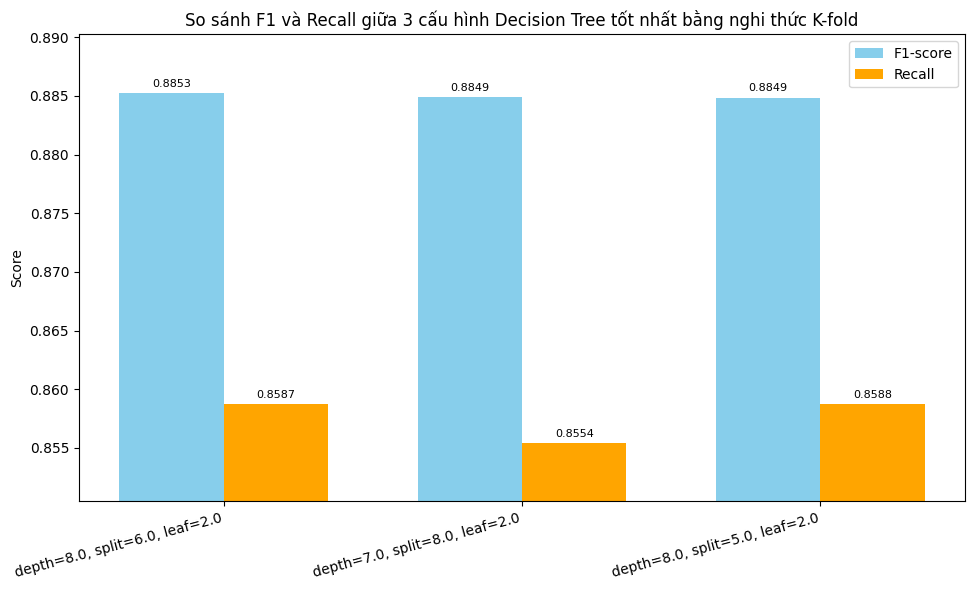

In [5]:
top3 = df_result_sorted.head(3).copy()

top3['label'] = top3.apply(
    lambda row: f"depth={row['max_depth']}, split={row['min_samples_split']}, leaf={row['min_samples_leaf']}", axis=1)

x = np.arange(len(top3))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width / 2, top3['mean_f1'], width, label='F1-score', color='skyblue')
rects2 = ax.bar(x + width / 2, top3['mean_recall'], width, label='Recall', color='orange')

ax.set_ylabel('Score')
ax.set_title('So sánh F1 và Recall giữa 3 cấu hình Decision Tree tốt nhất bằng nghi thức K-fold')
ax.set_xticks(x)
ax.set_xticklabels(top3['label'], rotation=15, ha='right')
ax.legend()

min_y = min(top3['mean_f1'].min(), top3['mean_recall'].min()) - 0.005
max_y = max(top3['mean_f1'].max(), top3['mean_recall'].max()) + 0.005
ax.set_ylim(min_y, max_y)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()